## Drive Link

https://drive.google.com/drive/folders/153ajbMSw4z8CW8p893wBjU9wKJRoNEeq

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import color as Color
from skimage import morphology as morp

In [2]:
# image folder path
folder = './../images'

# loads the image and converts it to rgb
def image(name):
    img = cv2.imread(folder + '/' + name)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# loads the image in grayscale format
def grayimage(name):
    img = cv2.imread(folder + '/' + name, cv2.IMREAD_GRAYSCALE)
    return img

# returns binary image
def binaryimage(img, t1, t2, t3=cv2.THRESH_BINARY):
    _, thresh = cv2.threshold(img, t1, t2, t3)
    return thresh

# rgb to gray
def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# resizes image
def resize(img, size):
    return cv2.resize(img, size, interpolation = cv2.INTER_NEAREST)

# adds padding to image
def add_padding(img, k1, k2, val=0):
    h, w = img.shape
    c1, c2 = k1//2, k2//2
    out = np.full((h+k1-1, w+k2-1), val, dtype=img.dtype)
    out[c1:c1+h, c2:c2+w] = img
    return out

# linear mapping of images to [low, high]
def lin_map(img, low=0, high=255):
    mn, mx = np.min(img), np.max(img)
    if mn == mx:
        img[:] = low
    else:
        img = (img-mn)/(mx-mn)*(high-low)+low
    return np.round(img).astype('uint8')

# log mapping of images
def log_map(img):
    img = np.log(1+img)
    return lin_map(img)

# plots image
def imshow(img, plot=plt):
    plot.imshow(img, cmap='gray', vmin=0, vmax=255)
    plot.axis('off')
    
# plotting many images
def plot(imgs, shape=None):
    if shape != None:
        plt.figure(figsize=shape)
    m = len(imgs)
    for i in range(1, m+1):
        plt.subplot(1, m, i)
        imshow(imgs[i-1])

## Task 1

Skeletonization, the basic idea is to remove any pixel on the boundary
of the foreground which has more than one foreground neighbor.

(480, 400)


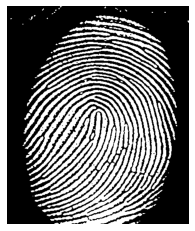

In [385]:
thumb = grayimage('thumb_print.jpg')
thumb = binaryimage(thumb, 127, 255, 1)
print(thumb.shape)
imshow(thumb)

In [386]:
def rotate90(s):
    return s[:, ::-1].T

def HAM(img, s):
    h, w = img.shape
    k1, k2 = s.shape
    c1, c2 = k1//2, k2//2
    
    out = np.zeros((h, w), dtype=img.dtype)
    img = add_padding(img, k1, k2)
    
    for i in range(h):
        for j in range(w):
            stop = 0
            for m in range(k1):
                for n in range(k2):
                    if s[m][n] == -1: continue
                    if img[i+m][j+n] != s[m][n] * 255:
                        out[i][j] = img[i+c1][j+c2]
                        stop = 1
                        break
                if stop: break
    return out

In [398]:
def skeletonization(img):
    # -1 is don't care
    s1 = np.array([[0, 0, 0], [-1, 1, -1], [1, 1, 1]])
    s2 = np.array([[-1, 0, 0], [1, 1, 0], [-1, 1, -1]])
    prev = np.zeros(img.shape, dtype=img.dtype)
    it = 0
    while not (img == prev).all():
        it += 1
        prev = img.copy()
        img = HAM(img, s1)
        if not (img == prev).all():
            it += 1
            prev = img.copy()
            img = HAM(img, s2)
        s1 = rotate90(s1)
        s2 = rotate90(s2)
    print(f"Total iterations: {it}")
    return img

### Task 1.1

In morphological operations, note that a structuring element whose origin is placed on a pixel will be compared to the corresponding neighborhood and if they match,
then the corresponding pixel in the output image is usually set to foreground. In this case, suppose that we change the rule and set the pixel to background.

Total iterations: 53


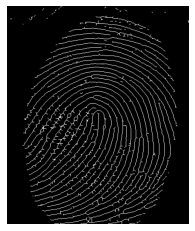

In [391]:
imshow(skeletonization(thumb))

### Task 1.2

Explain the role of structuring elements S1 , S2.

**Role of structuring elements**

1. S1: Finding the white edges lower and closer to the black pixels.
2. S2: Detecting right triangles, curving, corner white pixels.

### Task 1.3

By analyzing the outputs at the end of each skeletonization pass, explain why multiple passes are/may be required.

**Reason**

1. Multiple passes are required as each pass is thinning the skeleton a little and the image is very thick initially.

### Task 1.4

Try out the skeletonization algorithm described above on dragon.jpg,
butterfly.jpg and keyhole.jpg and comment on what you observe.

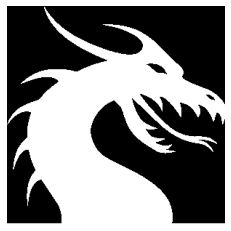

In [392]:
out = grayimage('dragon.png')
out = binaryimage(out, 127, 255)
imshow(out)

Total iterations: 385


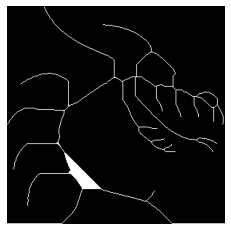

In [393]:
imshow(skeletonization(out))

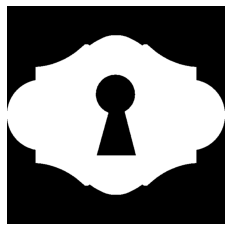

In [394]:
out = grayimage('keyhole.jpg')
out = binaryimage(out, 127, 255)
imshow(out)

Total iterations: 1137


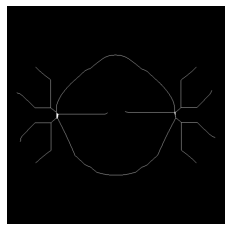

In [395]:
imshow(skeletonization(out))

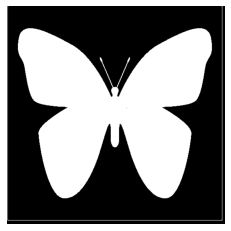

In [396]:
out = grayimage('butterfly.jpg')
out = binaryimage(out, 127, 255)
imshow(out)

Total iterations: 619


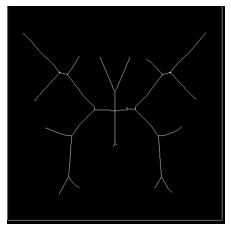

In [397]:
imshow(skeletonization(out))

**Observation**

1. The process of skeletonization is very inefficient, it's taking a large iterations to converge.

## Task 2

Find the organs of interest in the provided CT image kidney.jpg.

In [100]:
def getparent(x, components):
    if components[x][0] != x:
        components[x][0] = getparent(components[x][0], components)
    return components[x][0]
    
def union(x, y, components):
    x = getparent(x, components)
    y = getparent(y, components)
    if x == y: return
    if components[x][1] > components[y][1]:
        components[y][0] = x
        components[x][1] += 1
    else:
        components[x][0] = y
        components[y][1] += 1

def connectedComponents(img, conn=8):
    h, w = img.shape
    out = np.zeros((h, w), dtype='int64')
    components = {0: [0, 0]}
    
    cnt = 1
    # first pass, 8 connectivity
    if conn == 8:
        for i in range(h):
            for j in range(w):
                if img[i][j] == 0: continue
                for k in range(i-1, i+1):
                    for l in range(j-1, j+2):
                        if k < 0 or l < 0 or k >= h or l >= w or out[k][l] == 0: continue
                        if out[i][j] == 0: out[i][j] = out[k][l]
                        else: union(out[i][j], out[k][l], components)
                if out[i][j] == 0:
                    out[i][j] = cnt
                    components[cnt] = [cnt, 0]
                    cnt += 1
    # first pass, 4 connectivity
    else:
        for i in range(h):
            for j in range(w):
                if img[i][j] == 0: continue
                if j-1 >= 0 and out[i][j-1] != 0:
                    out[i][j] = out[i][j-1]
                if i-1 >= 0 and out[i-1][j] != 0:
                    if out[i][j] == 0: out[i][j] = out[i-1][j]
                    else: union(out[i][j], out[i-1][j], components)
                if out[i][j] == 0:
                    out[i][j] = cnt
                    components[cnt] = [cnt, 0]
                    cnt += 1
    
    # second pass
    cnt = 1
    cmp = {0: 0}
    for i in range(h):
        for j in range(w):
            out[i][j] = getparent(out[i][j], components)
            if out[i][j] in cmp: out[i][j] = cmp[out[i][j]]
            else:
                cmp[out[i][j]] = cnt
                out[i][j] = cnt
                cnt += 1
    
    # total components
    cnt = len(cmp) - 1
    
    return cnt, out        

In [133]:
# opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
# closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
# kernel = np.ones((5,5),np.uint8)
# cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
# erosion = cv2.erode(img,kernel,iterations = 1)

(512, 512)


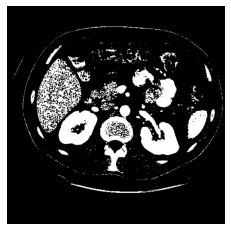

In [94]:
kidney = grayimage('kidney.jpg')
# thresholding image
kidney = binaryimage(kidney, 132, 255)
print(kidney.shape)
imshow(kidney)

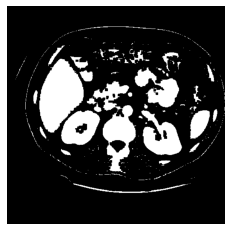

In [95]:
# closing
kernel = np.ones((3,2),np.uint8)
closing = cv2.morphologyEx(kidney, cv2.MORPH_CLOSE, kernel, iterations=2)
kernel = np.ones((1,2),np.uint8)
closing = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, kernel, iterations=4)
imshow(closing)

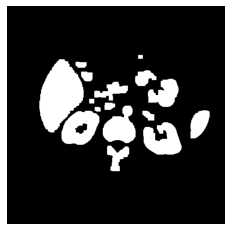

In [96]:
# opening
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=4)
imshow(opening)

In [97]:
cnt, out = connectedComponents(opening, 4)
print(f"Components {cnt}")

Components 16


In [98]:
label = Color.label2rgb(out, bg_label=0)

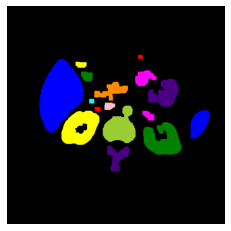

In [99]:
imshow(label)

## Task 3

(773, 444)


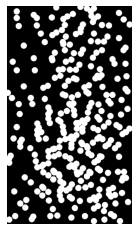

In [11]:
coins = grayimage('coins.jpg')
coins = binaryimage(coins, 127, 255)
print(coins.shape)
imshow(coins)

### Task 3.1

Only the coins touching the boundary of the image

In [17]:
def coins_touching_boundary(img):
    r = 9
    kernel = morp.disk(r, dtype='uint8')
    out = cv2.erode(img, kernel, iterations = 1)
    out[r: -r, r: -r] = 0
    out = cv2.dilate(out, kernel, iterations = 1)
    cnt, _ = connectedComponents(out)
    return cnt, out

No. of coins touching boundary: 11


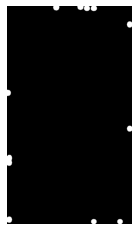

In [18]:
# coins touching the boundary of the image

cnt, out = coins_touching_boundary(coins)
print(f"No. of coins touching boundary: {cnt}")
imshow(out)

### Task 3.3

Only non overlapping coins

In [12]:
def non_overlapping_coins(img):
    out = cv2.erode(img, morp.disk(1))
    ker = morp.disk(6)
    ker1 = np.zeros((25, 25))
    ker1[6:19,6:19] = ker
    ker1[0,:] = -1
    ker1[-1,:] = -1
    ker1[:,0] = -1
    ker1[:,-1] = -1
    out = cv2.morphologyEx(out, cv2.MORPH_HITMISS, ker1)
    out = cv2.dilate(out, morp.disk(10))
    cnt, _ = connectedComponents(out)
    return cnt, out

No. of non overlapping coins: 72


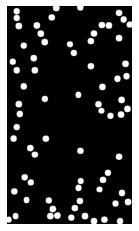

In [13]:
# non - overlapping coins

cnt, out = non_overlapping_coins(coins)
print(f"No. of non overlapping coins: {cnt}")
imshow(out)

### Task 3.2

Only overlapping coins

In [14]:
def overlapping_coins(img):
    cnt, out = non_overlapping_coins(img)
    out = img - out
    out = cv2.morphologyEx(out, cv2.MORPH_OPEN, morp.disk(9))
    cnt, _ = connectedComponents(out)
    return cnt, out

No. of overlapping coins: 67


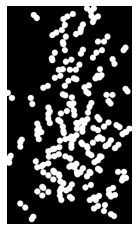

In [16]:
# overlapping coins

cnt, out = overlapping_coins(coins)
print(f"No. of overlapping coins: {cnt}")
imshow(out)

## Task 4

(331, 384)


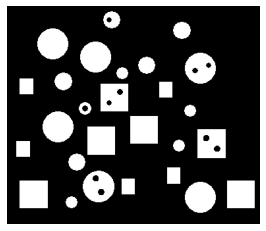

In [84]:
obj = grayimage('objects.png')
obj = binaryimage(obj, 127, 255)
print(obj.shape)
imshow(obj)

### Task 4.1

How many objects have one or more holes?

In [60]:
def obj_with_holes(img):
    cnt, out = connectedComponents(img)
    count = 0
    for i in range(1, cnt+1):
        tmp = np.where(out != i, 255, 0)
        x, _ = connectedComponents(tmp)
        if x > 1:
            count += 1
    return count

def obj_without_holes(img):
    cnt, _ = connectedComponents(img)
    count = obj_with_holes(img)
    return cnt - count

In [61]:
print(f"No. of objects with one or more hole is {obj_with_holes(obj)}")

No. of objects with one or more hole is 6


### Task 4.2

How many square objects are in the image?

In [85]:
def count_squares(img):
    cnt, out = connectedComponents(img)
    _, n = out.shape
    img = np.zeros(img.shape, dtype=img.dtype)
    count = 0
    for i in range(1, cnt+1):
        # taking one component at a time
        tmp = np.where(out == i, 255, 0).astype('uint8')
        # kernel for finding top left corner
        kernel = np.full((3, 3), -1)
        kernel[1:3, 1:3] = 1
        out1 = cv2.morphologyEx(tmp, cv2.MORPH_HITMISS, kernel)
        # if no corner found, then it's a circle, continue
        if np.max(out1) == 0: continue
        # finding bottom left corner
        kernel = rotate90(kernel)
        out2 = cv2.morphologyEx(tmp, cv2.MORPH_HITMISS, kernel)
        # calculating length
        d1 = abs(np.argmax(out2)//n - np.argmax(out1)//n)
        # finding bottom right corner
        kernel = rotate90(kernel)
        out3 = cv2.morphologyEx(tmp, cv2.MORPH_HITMISS, kernel)
        # calculating breadth
        d2 = abs(np.argmax(out3)%n - np.argmax(out2)%n)
        # if length == breadth, count++
        if d2 == d1:
            img |= tmp
            count += 1
    imshow(img)
    return count

No. of squares: 3


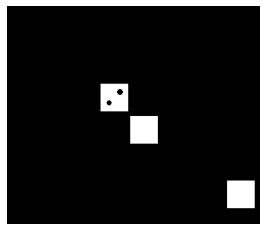

In [86]:
print(f"No. of squares: {count_squares(obj)}")

### Task 4.3

Identify the square objects that have holes.

In [87]:
def squares_with_holes(img):
    cnt, out = connectedComponents(img)
    _, n = out.shape
    img = np.zeros(img.shape, dtype=img.dtype)
    for i in range(1, cnt+1):
        tmp = np.where(out == i, 255, 0).astype('uint8')
        kernel = np.full((3, 3), -1)
        kernel[1:3, 1:3] = 1
        out1 = cv2.morphologyEx(tmp, cv2.MORPH_HITMISS, kernel)
        if np.max(out1) == 0: continue
        kernel = rotate90(kernel)
        out2 = cv2.morphologyEx(tmp, cv2.MORPH_HITMISS, kernel)
        d1 = abs(np.argmax(out2)//n - np.argmax(out1)//n)
        kernel = rotate90(kernel)
        out3 = cv2.morphologyEx(tmp, cv2.MORPH_HITMISS, kernel)
        d2 = abs(np.argmax(out3)%n - np.argmax(out2)%n)
        if d2 == d1:
            img |= tmp
    return obj_with_holes(img)

In [88]:
print(f"No. of squares with holes is {squares_with_holes(obj)}")

No. of squares with holes is 1


### Task 4.4

Identify the circular objects that have no holes

In [91]:
def circles_without_holes(img):
    cnt, out = connectedComponents(img)
    _, n = out.shape
    img = np.zeros(img.shape, dtype=img.dtype)
    for i in range(1, cnt+1):
        tmp = np.where(out == i, 255, 0).astype('uint8')
        kernel = np.full((3, 3), -1)
        kernel[1:3, 1:3] = 1
        out1 = cv2.morphologyEx(tmp, cv2.MORPH_HITMISS, kernel)
        if np.max(out1) == 0:
            img |= tmp
    return obj_without_holes(img)

In [92]:
print(f"No. of circles without holes is {circles_without_holes(obj)}")

No. of circles without holes is 12


## Task 5

### Task 5.1

Write a script which takes the image as input and outputs the number of components for each of the five colors.

(678, 871, 3)


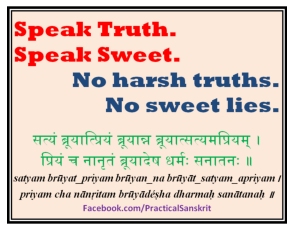

In [116]:
text = image('colourful_text.png')
print(text.shape)
imshow(text)

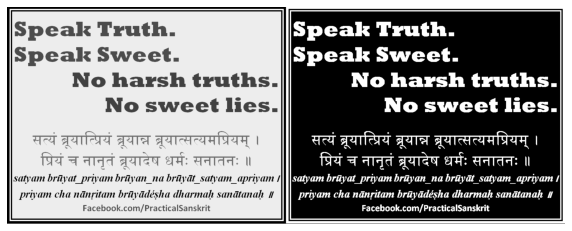

In [129]:
plt.figure(figsize=(10, 6))
imshow(np.hstack([rgb2gray(text), binaryimage(rgb2gray(text), 235, 255, 1)]))

In [172]:
def colour_wise_components(img):
    img = rgb2gray(img)
    col, fre = np.unique(img, return_counts=True)
    idx = np.argsort(fre)
    col = col[idx][::-1][1:]
    color = {}
    cnt = 0
    for i in range(col.shape[0]):
        if col[i] == 255: continue
        cnt += 1
        out = np.where(img == col[i], 255, 0)
        x, _ = connectedComponents(out)
        color[col[i]] = x
        if cnt == 5: break
    return color

In [173]:
color = colour_wise_components(text)
color

{0: 243, 66: 27, 76: 24, 112: 74, 80: 34}

Components: 22


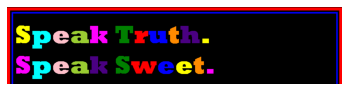

In [175]:
cnt, out = connectedComponents(binaryimage(rgb2gray(text[:200, :]), 235, 255, 1))
print(f"Components: {cnt-2}")
label = Color.label2rgb(out, bg_label=0)
imshow(label)

Components: 27


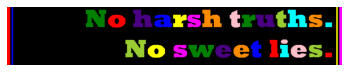

In [178]:
cnt, out = connectedComponents(binaryimage(rgb2gray(text[200:350, :]), 235, 255, 1))
print(f"Components: {cnt-4}")
label = Color.label2rgb(out, bg_label=0)
imshow(label)

Components: 25


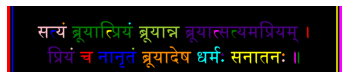

In [180]:
cnt, out = connectedComponents(binaryimage(rgb2gray(text[350:520, :]), 235, 255, 1))
print(f"Components: {cnt-4}")
label = Color.label2rgb(out, bg_label=0)
imshow(label)

Components: 83


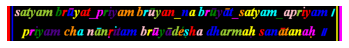

In [181]:
cnt, out = connectedComponents(binaryimage(rgb2gray(text[520:610, :]), 235, 255, 1))
print(f"Components: {cnt-4}")
label = Color.label2rgb(out, bg_label=0)
imshow(label)

Components: 32


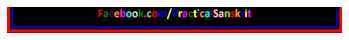

In [182]:
cnt, out = connectedComponents(binaryimage(rgb2gray(text[610:, :]), 235, 255, 1))
print(f"Components: {cnt-2}")
label = Color.label2rgb(out, bg_label=0)
imshow(label)

### Task 5.2

In [196]:
tamil = grayimage('tamil.jpeg')
tamil = cv2.adaptiveThreshold(tamil, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 20)
print(tamil.shape)
telugu = grayimage('telugu.jpeg')
telugu = cv2.adaptiveThreshold(telugu, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 20)
print(telugu.shape)

(452, 602)
(339, 602)


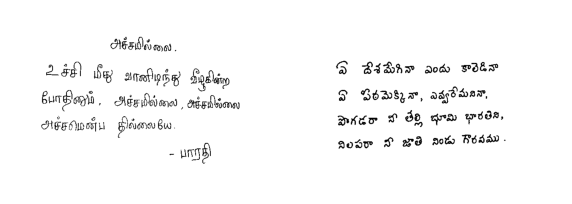

In [205]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
imshow(tamil)
plt.subplot(122)
imshow(telugu)

In [204]:
def letters_with_region(img, region):
    img = 255 - img
    cnt, out = connectedComponents(img)
    img = np.zeros(img.shape, dtype=img.dtype)
    count = 0
    for i in range(1, cnt+1):
        tmp = np.where(out == i, 0, 255).astype('uint8')
        x, _ = connectedComponents(tmp)
        if x == region + 1:
            img |= 255 - tmp
            count += 1
    return count, 255 - img

#### Task 5.2.1

Binary image of only those letters that enclose one empty region (e.g. examples of English letters containing a single empty region are - o,e,a)

Tamil letters with one empty region is 27


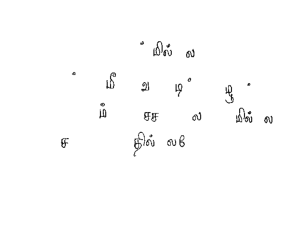

In [207]:
cnt, out = letters_with_region(tamil, 1)
print(f"Tamil letters with one empty region is {cnt}")
imshow(out)

Telugu letters with one empty region is 41


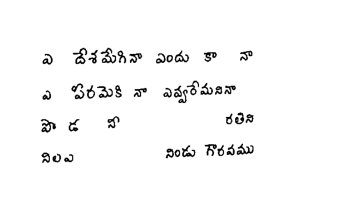

In [208]:
cnt, out = letters_with_region(telugu, 1)
print(f"Telugu letters with one empty region is {cnt}")
imshow(out)

#### Task 5.2.2

Binary image of only those letters that enclose one empty region (e.g. examples of English letters containing a single empty region are - o,e,a)

Tamil letters with two empty region is 19


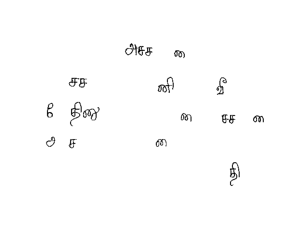

In [209]:
cnt, out = letters_with_region(tamil, 2)
print(f"Tamil letters with two empty region is {cnt}")
imshow(out)

Telugu letters with two empty region is 6


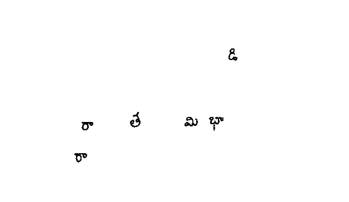

In [210]:
cnt, out = letters_with_region(telugu, 2)
print(f"Telugu letters with two empty region is {cnt}")
imshow(out)

## Task 6

In [344]:
img = rgb2gray(text)

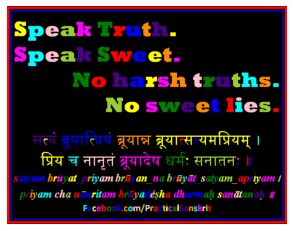

In [324]:
_, label = connectedComponents(binaryimage(rgb2gray(text), 235, 255, 1))
imshow(Color.label2rgb(label, bg_label=0))

### Task 6.1

How do you upscale the label map by factor k?

Label map should be upscaled by using INTER_NEAREST interpolation as nearest interpolation will choose nearest label whereas other interpolation will create a label which may not match with any of the neighbour label and will create a new object.
It is shown below, inter_nearest interpolation looks same as original, inter_cubic looks different.

In [356]:
def upscale_by_k(img, k, interpolation=cv2.INTER_NEAREST):
    size = (int(img.shape[1]*k), int(img.shape[0]*k))
    return cv2.resize(img.astype('uint8'), size, interpolation=interpolation).astype('int64')

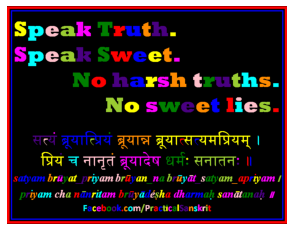

In [357]:
# correct upscaling using nearest interpolation
imshow(Color.label2rgb(upscale_by_k(label, 2, cv2.INTER_NEAREST), bg_label=0))

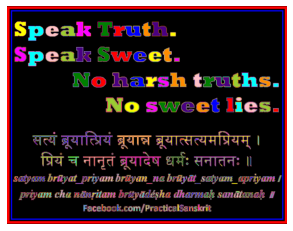

In [358]:
# incorrect upscaling
imshow(Color.label2rgb(upscale_by_k(label, 2, cv2.INTER_CUBIC), bg_label=0))

### Task 6.2

How do you rotate the label map by θ?

Label map should be rotated by using INTER_NEAREST interpolation as nearest interpolation will choose nearest label whereas other interpolation will create a label which may not match with any of the neighbour label and will create a new object.
It is shown below, inter_nearest interpolation looks same as original, inter_cubic looks different.

In [359]:
def rotate_by_k(img, angle, interpolation=cv2.INTER_NEAREST):
    center = (img.shape[1] // 2, img.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img.astype('uint8'), rot_mat, img.shape[1::-1], flags=interpolation).astype('int64')

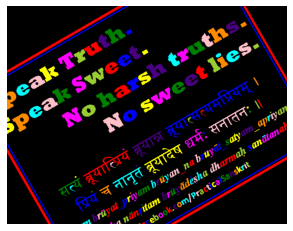

In [360]:
# correct rotation using nearest interpolation
imshow(Color.label2rgb(rotate_by_k(label, 30, cv2.INTER_NEAREST), bg_label=0))

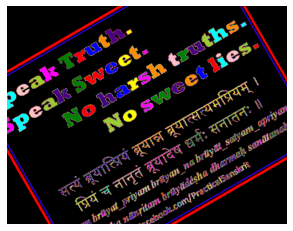

In [361]:
# incorrect rotation
imshow(Color.label2rgb(rotate_by_k(label, 30, cv2.INTER_CUBIC), bg_label=0))

## Task 7

Write a function rotImage

In [315]:
def rotImage(img, angle, retain=True):
    if len(img.shape) == 2:
        img = img.reshape((*img.shape, 1))
    angle = - np.pi / 180 * angle
    kernel = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    m, n, _ = img.shape
    dim = 2 * max(m, n)
    c = dim // 2
    idx = []
    for i in range(-c, -c+dim):
        for j in range(-c, -c+dim):
            idx.append([i, j])
    # new image coordinates
    idx = np.array(idx).T
    # new image coordinates mapped to old image coordinaes
    nidx = kernel @ idx
    # nearest neighbour interpolation
    nidx = np.round(nidx).astype('int64')
    idx[0:1, :] += c
    idx[1:2, :] += c
    nidx[0:1, :] += m // 2
    nidx[1:2, :] += n // 2
    out = np.zeros((dim, dim, img.shape[-1]), dtype=img.dtype)
    x1, y1 = c - m//2, c - n//2
    x2, y2 = x1 + m, y1 + n
    for i in range(idx.shape[1]):
        if nidx[0][i] >= 0 and nidx[0][i] < m and nidx[1][i] >= 0 and nidx[1][i] < n: 
            out[idx[0][i]][idx[1][i]] = img[nidx[0][i]][nidx[1][i]]
            if not retain:
                x1, x2 = min(x1, idx[0][i]), max(x2, idx[0][i])
                y1, y2 = min(y1, idx[1][i]), max(y2, idx[1][i])
    if out.shape[-1] == 1:
        out = out.reshape((*out.shape[:-1]))
    return out[x1:x2, y1:y2]

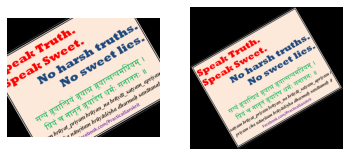

In [307]:
plot([rotImage(text, 30, True), rotImage(text, 30, False)])

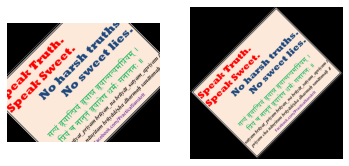

In [311]:
plot([rotImage(text, 45, True), rotImage(text, 45, False)])

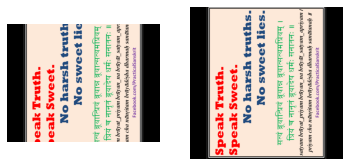

In [312]:
plot([rotImage(text, 90, True), rotImage(text, 90, False)])

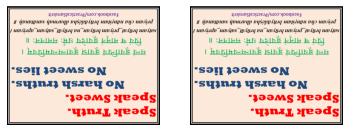

In [313]:
plot([rotImage(text, 180, True), rotImage(text, 180, False)])

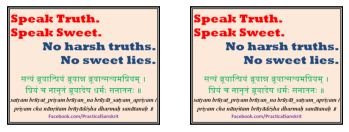

In [314]:
plot([rotImage(text, 360, True), rotImage(text, 360, False)])